In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [18]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [19]:
sentiment = pd.read_csv('/content/fear_greed_index.csv')
trades = pd.read_csv('/content/historical_data.csv')

In [20]:
print("Sentiment columns:", sentiment.columns)
print("Trades columns:", trades.columns)

Sentiment columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Trades columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [21]:
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')
sentiment.rename(columns={'classification':'Classification'}, inplace=True)

In [22]:
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trades['trade_date'] = trades['Timestamp IST'].dt.date

In [23]:
sentiment['trade_date'] = sentiment['date'].dt.date

In [24]:
merged = trades.merge(sentiment[['trade_date','Classification']], on='trade_date', how='left')
print("Merged data shape:", merged.shape)
print(merged[['Account','Coin','Execution Price','Size USD','Closed PnL','Fee','Classification']].head())

Merged data shape: (211224, 18)
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size USD  Closed PnL       Fee Classification  
0   7872.16         0.0  0.345404  Extreme Greed  
1    127.68         0.0  0.005600  Extreme Greed  
2   1150.63         0.0  0.050431  Extreme Greed  
3   1142.04         0.0  0.050043  Extreme Greed  
4     69.75         0.0  0.003055  Extreme Greed  


In [25]:
merged['notional'] = merged['Size USD']

In [26]:
daily = merged.groupby(['trade_date','Classification']).agg(
    total_volume=('notional','sum'),
    avg_fee=('Fee','mean'),
    avg_pnl=('Closed PnL','mean'),
    num_trades=('Account','count')
).reset_index()
print("\nDaily summary:")
print(daily.head())


Daily summary:
   trade_date Classification  total_volume   avg_fee    avg_pnl  num_trades
0  2023-05-01          Greed        477.00  0.000000   0.000000           3
1  2023-12-05  Extreme Greed      50005.83  1.389051   0.000000           9
2  2023-12-14          Greed     113203.35  2.572803 -18.675885          11
3  2023-12-15          Greed      10609.95  1.326245 -12.316017           2
4  2023-12-16          Greed      15348.77  1.279063   0.000000           3


In [27]:
summary = daily.groupby('Classification')[['total_volume','avg_fee','avg_pnl','num_trades']].mean()
print("\nAverage metrics under Fear vs Greed:\n", summary)


Average metrics under Fear vs Greed:
                 total_volume   avg_fee    avg_pnl   num_trades
Classification                                                
Extreme Fear    8.177447e+06  0.938658  38.433903  1528.571429
Extreme Greed   1.091800e+06  1.044605  56.736108   350.807018
Fear            5.311261e+06  2.211484  31.276567   679.527473
Greed           1.495246e+06  1.886188  39.412175   260.637306
Neutral         2.690180e+06  2.279741  63.820699   562.477612


In [28]:
os.makedirs('outputs', exist_ok=True)
os.makedirs('csv_files', exist_ok=True)

/tmp/ipython-input-1033956184.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=daily, x='Classification', y='avg_pnl', palette='coolwarm')


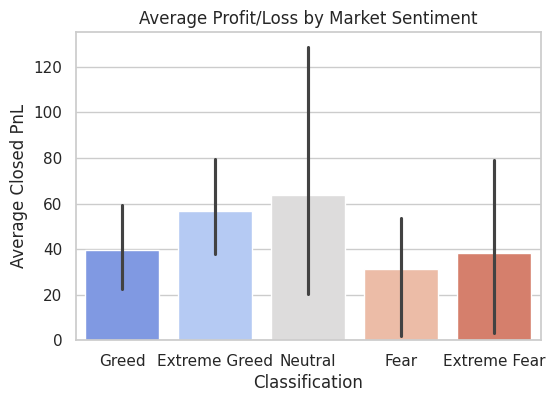

/tmp/ipython-input-1033956184.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=daily, x='Classification', y='total_volume', palette='viridis')


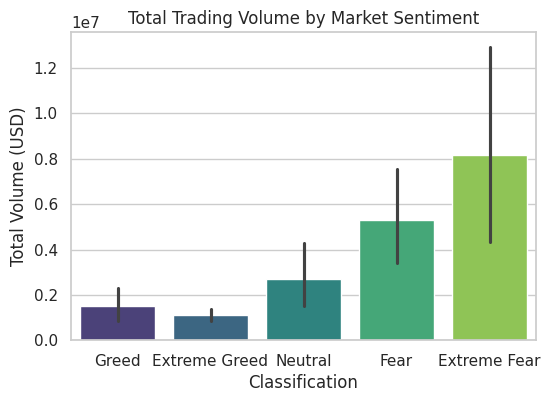

In [29]:
# Average PnL by sentiment
plt.figure(figsize=(6,4))
sns.barplot(data=daily, x='Classification', y='avg_pnl', palette='coolwarm')
plt.title('Average Profit/Loss by Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.savefig('outputs/avg_pnl_by_sentiment.png', bbox_inches='tight')
plt.show()

# Total volume by sentiment
plt.figure(figsize=(6,4))
sns.barplot(data=daily, x='Classification', y='total_volume', palette='viridis')
plt.title('Total Trading Volume by Market Sentiment')
plt.ylabel('Total Volume (USD)')
plt.savefig('outputs/total_volume_by_sentiment.png', bbox_inches='tight')
plt.show()

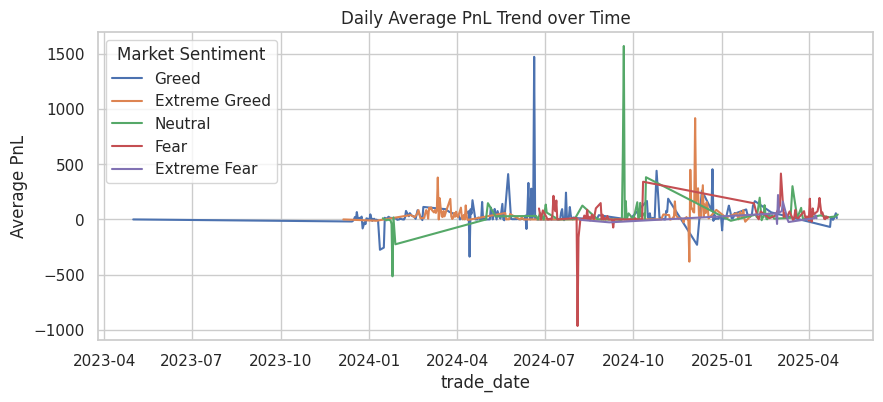

/tmp/ipython-input-995192568.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily, x='Classification', y='avg_fee', palette='Set2')


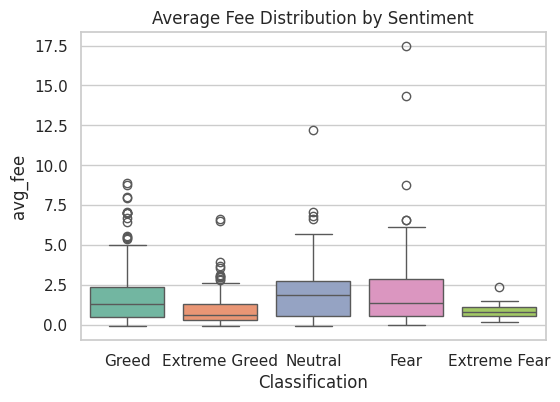

In [31]:
# Daily avg PnL trend
plt.figure(figsize=(10,4))
sns.lineplot(data=daily, x='trade_date', y='avg_pnl', hue='Classification')
plt.title('Daily Average PnL Trend over Time')
plt.ylabel('Average PnL')
plt.legend(title='Market Sentiment')
plt.savefig('outputs/daily_pnl_trend.png', bbox_inches='tight')
plt.show()

# Fee vs Sentiment
plt.figure(figsize=(6,4))
sns.boxplot(data=daily, x='Classification', y='avg_fee', palette='Set2')
plt.title('Average Fee Distribution by Sentiment')
plt.savefig('outputs/fee_distribution.png', bbox_inches='tight')
plt.show()

In [33]:
daily.to_csv('csv_files/daily_summary.csv', index=False)
merged.to_csv('csv_files/merged_data.csv', index=False)

print("\n Analysis complete. Data and charts saved in folders.")


 Analysis complete. Data and charts saved in folders.
